In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, Dense, LayerNormalization, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Cargamos y Procesamos los datos de entrenamiento

In [62]:
# Lista de archivos CSV de diferentes empresas
companies = ["Global_Data_AAPL.csv", "Global_Data_MSFT.csv", "Global_Data_GOOGL.csv", "Global_Data_AMZN.csv", "Global_Data_TSLA.csv"]

# Cargamos y combinamos los datasets
dataframes = []
for file in companies:
    df = pd.read_csv(f"../Data/{file}")  
    dataframes.append(df)

# Unimos todos los datos en un solo DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Seleccionamos las variables que queremos utilizar para entrenar nuestro modelo
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal',
               'weighted_sentiment', 'sentiment_momentum', 'tweet_count'
               ]]

# Normalizamos los datos de las variables
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Creamos ventanas temporales
time_step = 20  # Tamaño de la ventana en días.

def create_dataset(dataset, target_column_index, time_step=time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), :])
        dataY.append(dataset[i + time_step, target_column_index])
    return np.array(dataX), np.array(dataY)

# Índice de la columna 'Close'
target_column_index = 3  
X, y = create_dataset(scaled_data, target_column_index, time_step=20)

# Dividimos los datos en entrenamiento (80%), validación (10%) y prueba (10%)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Datos de entrenamiento: {X_train.shape}, Datos de validación: {X_val.shape}, Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (4209, 20, 13), Datos de validación: (526, 20, 13), Datos de prueba: (527, 20, 13)


## Arquitectura del Modelo

In [63]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)

    return x + res

# Datos de entrada
seq_length = 20  # Longitud de la ventana
num_features = 13  # Número de variables

inputs = Input(shape=(seq_length, num_features))


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=(seq_length, num_features))
    x = inputs
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="elu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs, outputs)


In [67]:
input_shape = X_train.shape[1:]
print(input_shape)

model = build_model(
    input_shape,
    head_size=64, # Embedding size for attention
    num_heads=32, # Number of attention heads
    ff_dim=128, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=6,
    mlp_units=[256],
    mlp_dropout=0.3,
    dropout=0.2,
)

model.compile(
    loss="mean_squared_error",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["mean_squared_error"],
)

# Resumen del modelo
model.summary()

(20, 13)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 20, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 13)    │         26 │ input_layer_25[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 13)    │    112,653 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_200         │ (None, 20, 13)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_124 (Add)       │ (None, 20, 13)    │          0 │ dropout_200[0][0… │
│                     │                   │            │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 13)    │         26 │ add_124[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_150 (Dense)   │ (None, 20, 128)   │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_201         │ (None, 20, 128)   │          0 │ dense_150[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_151 (Dense)   │ (None, 20, 13)    │      1,677 │ dropout_201[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_125 (Add)       │ (None, 20, 13)    │          0 │ dense_151[0][0],  │
│                     │                   │            │ add_124[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 13)    │         26 │ add_125[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 13)    │    112,653 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_203         │ (None, 20, 13)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_126 (Add)       │ (None, 20, 13)    │          0 │ dropout_203[0][0… │
│                     │                   │            │ add_125[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 13)    │         26 │ add_126[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_152 (Dense)   │ (None, 20, 128)   │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_204         │ (None, 20, 128)   │          0 │ dense_152[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 20, 13)    │      1,677 │ dropout_204[0][0

 Total params: 702,677 (2.68 MB)

 Trainable params: 702,677 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Definimos los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/100


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - loss: 0.2076 - mean_squared_error: 0.2076
Epoch 1: val_loss improved from inf to 0.07890, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 885ms/step - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.0789 - val_mean_squared_error: 0.0789 - learning_rate: 1.0000e-05
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - loss: 0.0586 - mean_squared_error: 0.0586
Epoch 2: val_loss improved from 0.07890 to 0.06546, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 793ms/step - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.0655 - val_mean_squared_error: 0.0655 - learning_rate: 1.0000e-05
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - loss: 0.0507 - mean_squared_error: 0.0507
Epoch 3: val_loss improved from 0.06546 to 0.05882, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 767ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - val_loss: 0.0588 - val_mean_squared_error: 0.0588 

Es necesario aumentar el número de bloques de transformer ya que ahora el dataset contiene más variables que aprender. Cuantos más bloques se añaden, mayor es la capacidad del modelo para aprender distintas patrones de la sucuencia de entrada (las primeros bloques aprenden patrones básicos y los bloques profundos detectan características más complejas). También aumenta la capacidad de generalización del modelo sin sobreajustarse.

Por otro lado, ha sido necesario aumentar el dropout, ya que el aumento de variables beneficia al sobreajuste del modelo. Al añadir más bloques de transformer, aumenta la complejidad del modelo y con ello el número de parámetros entrenables, lo que aumenta también el riesgo de sobreajuste.

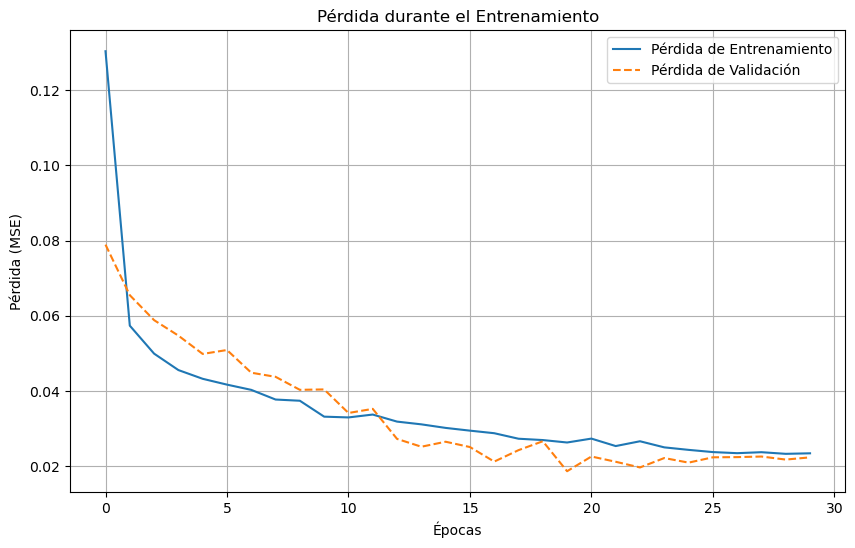

In [69]:
# Mostramos la gráfica de las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', linestyle='--')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.grid()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


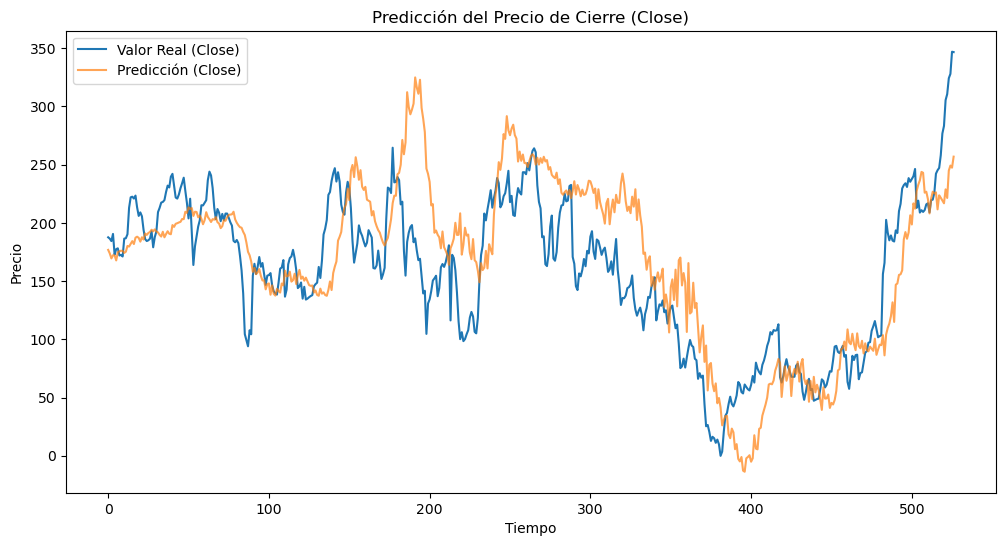

In [70]:
# Realizar predicciones
y_pred = model.predict(X_test)

# Desescalado de las predicciones (opcional, si deseas devolver los valores a la escala original)
y_test_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], X_test.shape[2]-1)), y_test.reshape(-1, 1)), axis=1)
)[:, -1]

y_pred_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred.shape[0], X_test.shape[2]-1)), y_pred), axis=1)
)[:, -1]

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Valor Real (Close)")
plt.plot(y_pred_original, label="Predicción (Close)", alpha=0.7)
plt.title("Predicción del Precio de Cierre (Close)")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()
